In [1]:
import os
import tensorflow
from tensorflow.python.keras.models import Model, load_model
import seaborn as sns
import numpy as np
from PIL import Image
import joblib
import os
import numpy as np
import pandas as pd
import random
import json
import cv2
import matplotlib.pyplot as plt
import requests

In [2]:
import sys
sys.path.append('/content/drive/MyDrive/projet_9')
from training_azure.dilatednet_hd import DilatedNet
from training_azure.multiclassunet import Unet

In [3]:
#set parameters
img_height, img_width = 256, 256
classes = 8
filters_n = 64

In [4]:
working_dir = '/content/drive/MyDrive/projet_9'
image_dir = os.path.join(working_dir, 'photo')
mask_dir = os.path.join(working_dir, 'mask')
augmented_dir = os.path.join(working_dir, 'augmented')
output_dir = os.path.join(working_dir, 'training_azure/models/model_v5_0.01_64')

In [5]:
#divison of labelling
cats = {'void': [0, 1, 2, 3, 4, 5, 6],
 'flat': [7, 8, 9, 10],
 'construction': [11, 12, 13, 14, 15, 16],
 'object': [17, 18, 19, 20],
 'nature': [21, 22],
 'sky': [23],
 'human': [24, 25],
 'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]}

In [9]:
test_model = DilatedNet(256, 256, 8,use_ctx_module=True, bn=True)
test_model.load_weights(output_dir+'/dilated.h5')

. . . . .Building DilatedNet. . . . .
. . . . .Building network successful. . . . .


In [10]:
image_test = []
image_test_dir = os.path.join(image_dir, 'test')
for root, dirs, files in os.walk(image_test_dir):
    for name in files:
        image_test.append(os.path.join(root, name))

mask_test = []
mask_test_dir = os.path.join(mask_dir, 'test')
for root, dirs, files in os.walk(mask_test_dir):
    for name in files:
      if '_labelIds' in name:
        mask_test.append(os.path.join(root, name))

image_test.sort()
mask_test.sort()


In [30]:
#function to visualize

def give_color_to_seg_img(seg, n_classes=classes):
    
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

In [26]:
def get_cat(mask_input, width=img_width, height=img_height):
  ''' Function that take a array mask of dimension (1024 2048)
    with 36 label and return a mask of dimension Height width with 8 labels'''
    
  img = mask_input
  mask = np.zeros((img.shape[0], img.shape[1], 8))
  for i in range(-1, 34):
      if i in cats['void']:
          mask[:,:,0] = np.logical_or(mask[:,:,0],(img==i))
      elif i in cats['flat']:
          mask[:,:,1] = np.logical_or(mask[:,:,1],(img==i))
      elif i in cats['construction']:
          mask[:,:,2] = np.logical_or(mask[:,:,2],(img==i))
      elif i in cats['object']:
          mask[:,:,3] = np.logical_or(mask[:,:,3],(img==i))
      elif i in cats['nature']:
          mask[:,:,4] = np.logical_or(mask[:,:,4],(img==i))
      elif i in cats['sky']:
          mask[:,:,5] = np.logical_or(mask[:,:,5],(img==i))
      elif i in cats['human']:
          mask[:,:,6] = np.logical_or(mask[:,:,6],(img==i))
      elif i in cats['vehicle']:
          mask[:,:,7] = np.logical_or(mask[:,:,7],(img==i)) 
  mask = cv2.resize(mask, (height, width))
  mask = np.argmax(mask, axis=-1)
  return mask

In [22]:
def preprocess(img):
    img = Image.open(img)
    img = np.array(img)
    img = cv2.resize(img, (img_height, img_width))
    img = img / 255.0
    return img

In [17]:
def outprocess(pred):
    pred = np.squeeze(pred)
    pred = pred.reshape(256, 256, 8)
    pred = cv2.resize(pred, (256, 256))
    pred = np.argmax(pred, axis=2)
    return pred

In [19]:
def display(image, truth, pred):
  fig, axs = plt.subplots(1,3, figsize=(20,20))
  image = preprocess(image)
  axs[0].imshow(image)
  axs[0].set_title('Image')

  truth = Image.open(truth)
  truth = np.array(truth)
  truth = get_cat(truth)
  truth = give_color_to_seg_img(truth)
  axs[1].imshow(truth)
  axs[1].set_title('Ground truth')

  pred = outprocess(pred)
  axs[2].imshow(pred)
  axs[2].set_title('Prediction')
  plt.show()

In [24]:
img = preprocess(image_test[3])
pred = test_model.predict(np.expand_dims(img, axis=0))

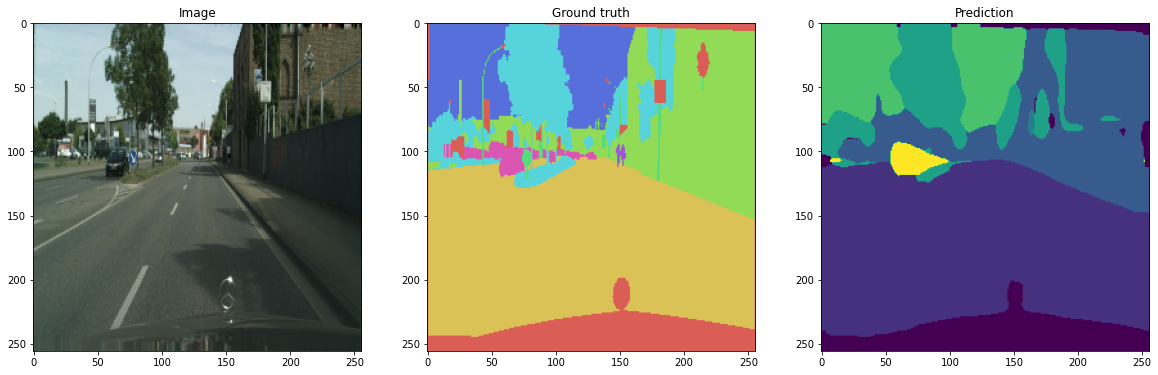

In [31]:
display(image_test[3], mask_test[3], pred)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')